# Sea Ice Concentration Pan01

In [1]:
import intake
from intake import cat
from xarray import DataTree, map_over_datasets

from dask.distributed import Client

import xarray as xr
import numpy as np
import cf_xarray as cfxr
import xesmf
import glob

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines

In [2]:
import json
import pandas as pd
from pathlib import Path
from datetime import timedelta


import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44025/status,
Dashboard: /proxy/44025/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43619,Workers: 0
Dashboard: /proxy/44025/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36337,Total threads: 1
Dashboard: /proxy/38623/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:46429,


## Importing the data
Giving intake a chance for once, hope I don't regret it

In [4]:
#Choose which model we are working with
# MODEL='cice5'
MODEL='sis2'

Making a catalog for both access experiments (can skip because already done):

In [5]:
import json
import pandas as pd
from pathlib import Path

# Paths to catalogs
control_json = Path('/home/272/kc5856/pan01_cont_dir/experiment_datastore.json')
melt_json = Path('/home/272/kc5856/catalog_dir/experiment_datastore.json')
combined_json = Path('/home/272/kc5856/pan01_combined.json')
combined_csv = Path('/home/272/kc5856/pan01_combined.csv')

# Load both JSON files
with open(control_json, 'r') as f:
    control = json.load(f)

with open(melt_json, 'r') as f:
    melt = json.load(f)

# Remove 'file:' prefix if present
control_catalog_file = control["catalog_file"].replace("file:", "")
melt_catalog_file = melt["catalog_file"].replace("file:", "")

# Get absolute CSV paths
control_csv = Path(control_catalog_file)
melt_csv = Path(melt_catalog_file)

# Read both CSVs
df_control = pd.read_csv(control_csv)
df_melt = pd.read_csv(melt_csv)

# Add a column to identify source (optional but useful)
df_control["source"] = "control"
df_melt["source"] = "meltwater"

# Combine them
df_combined = pd.concat([df_control, df_melt], ignore_index=True)

# Save combined CSV
df_combined.to_csv(combined_csv, index=False)

# Create new JSON (copy from one and update catalog_file)
combined_metadata = control.copy()
combined_metadata["catalog_file"] = combined_csv.name  # relative path

# Save combined JSON
with open(combined_json, 'w') as f:
    json.dump(combined_metadata, f, indent=2)

print(f"✅ Combined catalog saved to {combined_json}")


✅ Combined catalog saved to /home/272/kc5856/pan01_combined.json


In [5]:
catalog = intake.open_esm_datastore('/home/272/kc5856/pan01_combined.json', columns_with_iterables=['variable'])
catalog

,unique
filename,12381
file_id,13
path,12481
filename_timestamp,90
frequency,3
start_date,3985
end_date,3986
variable,122
variable_long_name,18
variable_standard_name,18


In [6]:
# Defining variables

sic_args = {
    "cice5": {  # ACCESS-OM2 sea ice
        "sources": ["control", "meltwater"],  # matches 'source' column in catalog
        "variable": "aice_m",
        "decode_coords": False
    },
    "sis2": {  # MOM6 testing
        "sources": ["control", "meltwater"], 
        "variable": "siconc",
        "decode_coords": False
    }
}

area_variable = {
    "cice5": "area_t",
    "sis2": "areacello"
}

geo_variables = {
    "cice5": ['geolon_t', 'geolat_t'],
    "sis2": ['geolon', 'geolat']
}

In [7]:
# Get sources and variable from config
sources = sic_args[MODEL]['sources']         # e.g., ['control', 'meltwater']
variable = sic_args[MODEL]['variable']       # e.g., 'aice_m'

# Search catalog for these sources and variable
cat_subset = catalog.search(source=sources)  # filter by source
var_search = cat_subset.search(variable=variable, frequency="1mon")  # add variable and frequency filter

In [8]:
MODEL = "sis2"
variable = sic_args[MODEL]['variable']
decode_coords = sic_args[MODEL]['decode_coords']

# Control
cat_control = catalog.search(source="control", variable=variable, frequency="1mon")
dset_control = cat_control.to_dask(
    xarray_open_kwargs=dict(decode_coords=decode_coords, chunks=-1),
    xarray_combine_by_coords_kwargs=dict(compat="override", data_vars="minimal", coords="minimal")
)
sic_C = list(dset_control.values())[0]  # DataArray already

# Meltwater
cat_melt = catalog.search(source="meltwater", variable=variable, frequency="1mon")
dset_melt = cat_melt.to_dask(
    xarray_open_kwargs=dict(decode_coords=decode_coords, chunks=-1),
    xarray_combine_by_coords_kwargs=dict(compat="override", data_vars="minimal", coords="minimal")
)
sic_M = list(dset_melt.values())[0]  # DataArray already


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTi

In [9]:
sic_C

<xarray.DataArray 'siconc' (time: 252, yT: 845, xT: 3600)> Size: 3GB
dask.array<concatenate, shape=(252, 845, 3600), dtype=float32, chunksize=(6, 845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xT       (xT) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yT       (yT) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * time     (time) object 2kB 1991-01-16 12:00:00 ... 2011-12-16 12:00:00
Attributes:
    units:          0-1
    long_name:      ice concentration
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [10]:
sic_M

<xarray.DataArray 'siconc' (time: 120, yT: 845, xT: 3600)> Size: 1GB
dask.array<concatenate, shape=(120, 845, 3600), dtype=float32, chunksize=(6, 845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xT       (xT) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yT       (yT) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          0-1
    long_name:      ice concentration
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

Another messy thing about CICE5 is that it thinks that monthly data for, say, January occurs at midnight on Jan 31 -- while xarray interprets this as the first milllisecond of February.

To get around this, note that we loaded data from February above, and we now subtract 12 hours from the time dimension. This means that, at least data is sitting in the correct month, and really helps to compute monthly climatologies correctly.

In [11]:
sic_C = sic_C.chunk({"time":11})
sic_C = sic_C.sel(time=slice("2001-01-01","2010-12-31"))

sic_M = sic_M.chunk({"time":11})
sic_M = sic_M.sel(time=slice("2001-01-01","2010-12-31"))

sic_C

<xarray.DataArray 'siconc' (time: 120, yT: 845, xT: 3600)> Size: 1GB
dask.array<getitem, shape=(120, 845, 3600), dtype=float32, chunksize=(11, 845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xT       (xT) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yT       (yT) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          0-1
    long_name:      ice concentration
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [12]:
var_search = catalog.search(variable=area_variable[MODEL])

dset = var_search.to_dask()

# dset is a dict of DataArrays; pick the first one
area = list(dset.values())[0].load()

area

<xarray.DataArray 'areacello' (yh: 845, xh: 3600)> Size: 12MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [78244536., 78244536., 78244536., ..., 78244536., 78244536.,
        78244536.],
       [78410056., 78410056., 78410056., ..., 78410056., 78410056.,
        78410056.],
       [78575632., 78575632., 78575632., ..., 78575632., 78575632.,
        78575632.]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
Attributes:
    units:          m2
    long_name:      Ocean Grid-Cell Area
    cell_methods:   area:sum yh:sum xh:sum time: point
    standard_name:  cell_area

In [13]:
## Corrected area
# Import a variable 
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))

def preprocess(ds):
    ds = ds['so']
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')

var = cont['so'].isel(time=0,z_l=0)

area_corr = area*(var*0 +1)

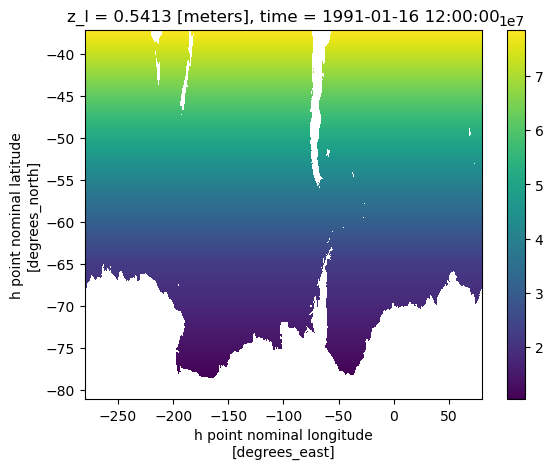

In [14]:
area_corr.plot()

#### Checking (xT,yT) and (xh,yh)
MOM6 and SIS2 share the same horizontal grid in most coupled configurations to avoid interpolation cost between ice and ocean.

MOM6 typically uses:

- xh, yh = tracer cell center longitudes/latitudes (scalar points).
- xq, yq = velocity grid (for U, V components).

SIS2 typically uses:

- xT, yT = tracer grid for ice variables (similar to MOM6's xh, yh).
- xU, yU and xV, yV for ice velocities (on C-grid).

In [15]:
# Confirming they are the same
np.allclose(sic_C.xT, area_corr.xh)
np.allclose(sic_C.yT, area_corr.yh)

True

Yay! So now I can just rename:

In [16]:
sic_C = sic_C.rename({'xT': 'xh', 'yT': 'yh'})
sic_M = sic_M.rename({'xT': 'xh', 'yT': 'yh'})

In [17]:
sic_C

<xarray.DataArray 'siconc' (time: 120, yh: 845, xh: 3600)> Size: 1GB
dask.array<getitem, shape=(120, 845, 3600), dtype=float32, chunksize=(11, 845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          0-1
    long_name:      ice concentration
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

## Sea Ice Area

Let's look at a timeseries of SO sea ice area. Area is defined (per convention) as the sum of sea ice concentration multiply by the area of each grid cell (and masked for sea ice concentration above 15%)

By convention, sea-ice area for a region or basin is the sum of the area's where concentration is greater than 15%. We also need to drop geolon and geolat so we have unique longitude and latitude to reference

In [18]:
# Mask SIC < 0.15
sic_C = sic_C.where(sic_C >= 0.15)
sic_M = sic_M.where(sic_M >= 0.15)

#### Time series on shelf

In [19]:
## Creating shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [20]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [21]:
# Apply shelf mask and compute sea ice area
si_area_C = sic_C.where(shelf_mask == 1) * area_corr
si_area_M = sic_M.where(shelf_mask == 1) * area_corr

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


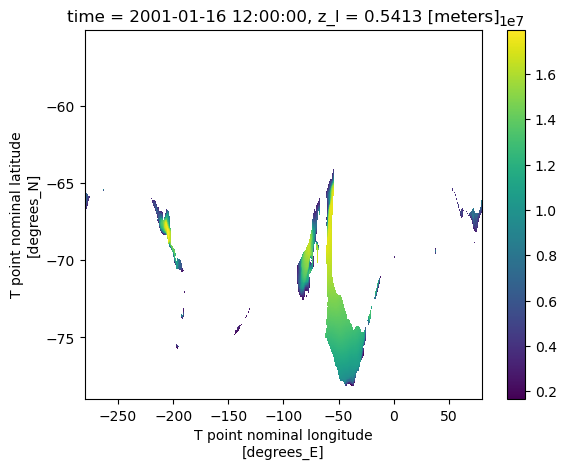

In [22]:
si_area_C.isel(time=0).plot()

In [23]:
# Sum over region (south of 40°S)
sic_C_SH_shelf_area = si_area_C.sel(yh=slice(None, -40)).sum(['xh', 'yh'])
sic_M_SH_shelf_area = si_area_M.sel(yh=slice(None, -40)).sum(['xh', 'yh'])

sic_M_SH_shelf_area

<xarray.DataArray (time: 120)> Size: 480B
dask.array<sum-aggregate, shape=(120,), dtype=float32, chunksize=(11,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
    z_l      float64 8B 0.5413

Note, this gives total sea ice area south of 40°S (with 15% threshold). If I want mean SIC, I need to divide by total area in the cell above. 

In [24]:
sic_C_SH_shelf_area = sic_C_SH_shelf_area.load()

In [25]:
sic_M_SH_shelf_area = sic_M_SH_shelf_area.load()

Text(0.5, 1.0, 'Sea Ice Area PanAn 1/10th')

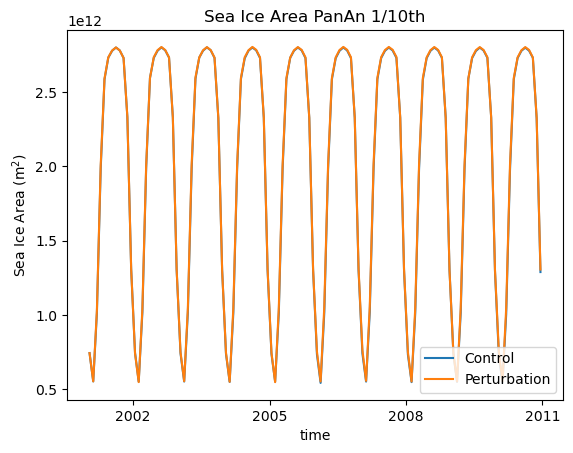

In [26]:
sic_C_SH_shelf_area.plot(label = 'Control')
sic_M_SH_shelf_area.plot(label = 'Perturbation')

plt.legend(loc='lower right')
plt.ylabel('Sea Ice Area (m$^{2}$)');
plt.title('Sea Ice Area PanAn 1/10th')

In [27]:
sic_shelf_anom = sic_M_SH_shelf_area - sic_C_SH_shelf_area
sic_shelf_anom = sic_shelf_anom.load()

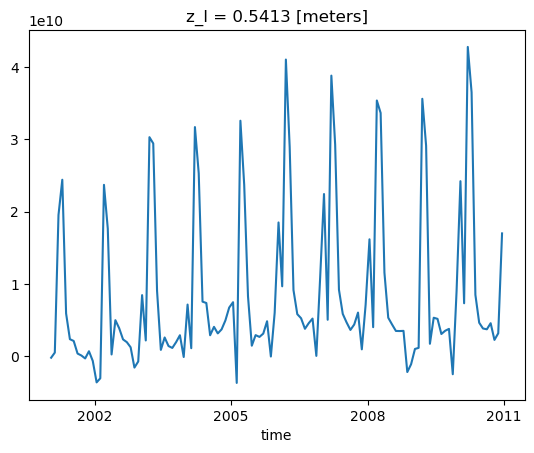

In [28]:
sic_shelf_anom.plot()

In [29]:
sic_shelf_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/sic_shelf_anom_pan01.nc')

#### Checking the seasonal cycle

Text(0, 0.5, 'Sea Ice Area (m$^{2}$)')

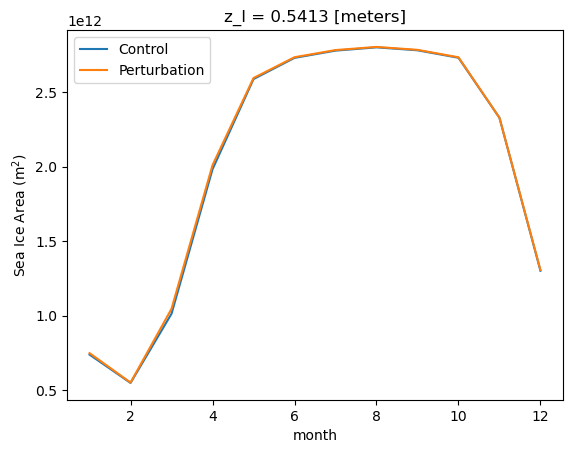

In [30]:
sic_C_SH_shelf_area.groupby('time.month').mean('time').plot(label='Control')
sic_M_SH_shelf_area.groupby('time.month').mean('time').plot(label='Perturbation')

plt.legend()
plt.ylabel('Sea Ice Area (m$^{2}$)')

In [31]:
sic_seasonal_anom = sic_M_SH_shelf_area.groupby('time.month').mean('time') - sic_C_SH_shelf_area.groupby('time.month').mean('time')

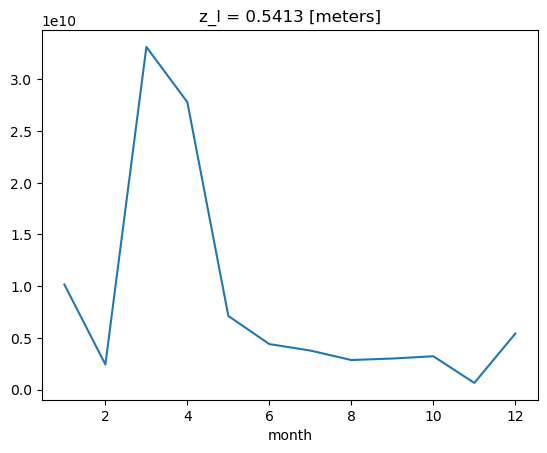

In [32]:
sic_seasonal_anom.plot()

In [33]:
sic_seasonal_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/sic_seasonal_anom_pan01.nc')

## Mapping

In [39]:
sic_C

<xarray.DataArray 'siconc' (time: 120, yh: 845, xh: 3600)> Size: 1GB
dask.array<where, shape=(120, 845, 3600), dtype=float32, chunksize=(11, 845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          0-1
    long_name:      ice concentration
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [51]:
sic_C_map = sic_C.sel(yh=slice(None, -40)).sel(time=slice("2006-01-01","2010-12-31")).mean(dim='time')
sic_M_map = sic_M.sel(yh=slice(None, -40)).sel(time=slice("2006-01-01","2010-12-31")).mean(dim='time')

In [52]:
sic_C_map_n = sic_C_map.fillna(0)
sic_M_map_n = sic_M_map.fillna(0)

In [53]:
sic_C_map_n

<xarray.DataArray 'siconc' (yh: 808, xh: 3600)> Size: 12MB
dask.array<where, shape=(808, 3600), dtype=float32, chunksize=(808, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 6kB -81.11 -81.07 -81.02 ... -40.18 -40.11 -40.03

In [54]:
sic_C_map_n = sic_C_map_n.load()

In [55]:
sic_M_map_n = sic_M_map_n.load()

In [56]:
sic_map_anom = sic_M_map_n - sic_C_map_n
sic_map_anom = sic_map_anom.load()

In [59]:
import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

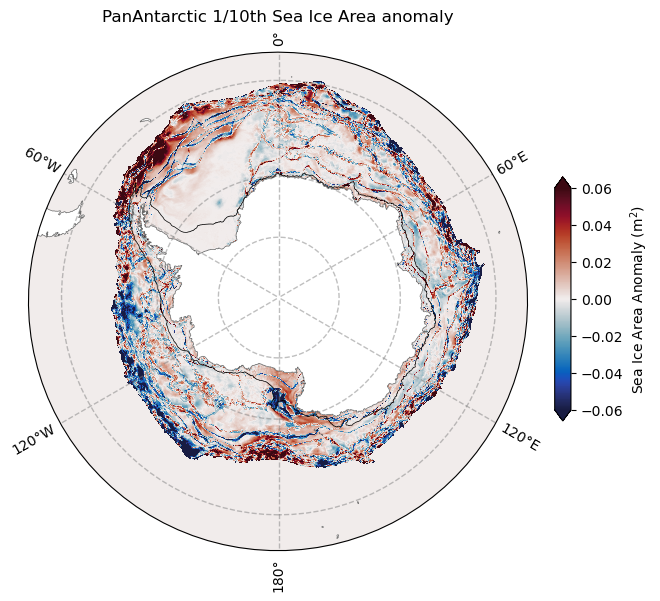

In [60]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

sic_map_anom.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Ice Area Anomaly (m$^{2}$)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/10th Sea Ice Area anomaly");

## Between model comparison

In [77]:
pan01_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/sic_shelf_anom_pan01.nc', chunks = 'auto') 
#pan005_botsalt_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/sic_shelf_anom_pan005.nc', chunks = 'auto')
acc_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/sic_shelf_anom_access.nc', chunks = 'auto') 

In [80]:
pan01_anom_new = pan01_anom.to_series()
#pan005_anom_new = pan005_anom.to_series()
acc_anom_new = acc_anom.to_series()

In [79]:
import pandas as pd

In [81]:
# Slice 1910–1919 and 2001–2010
pan01_anom_new = pan01_anom_new['2001-01-01':'2010-10-16']
#pan005_botsalt_anom_new = pan005_botsalt_anom_new['2001-01-01':'2010-10-16']
acc_anom_new = acc_anom_new['1910-01-01':'1919-10-16']

# Reset index to normalized months
pan01_anom_new.index = range(1, len(pan01_anom_new)+1)
#pan005_botsalt_anom_new.index = range(1, len(pan005_botsalt_anom_new)+1)
acc_anom_new.index = range(1, len(acc_anom_new)+1)

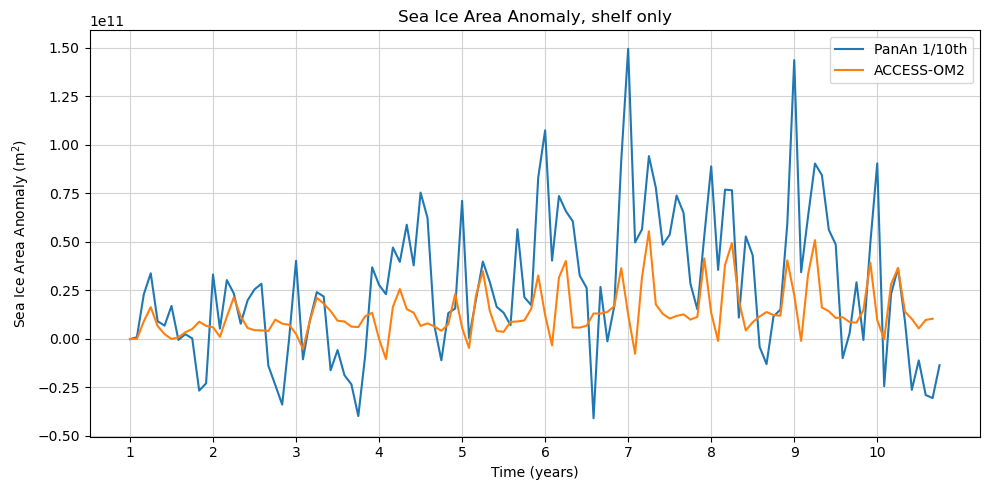

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(pan01_anom_new.index, pan01_anom_new.values, label='PanAn 1/10th')
#plt.plot(pan005_anom_new.index, pan005_anom_new.values, label='PanAn 1/20th')
plt.plot(acc_anom_new.index, acc_anom_new.values, label='ACCESS-OM2')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(1, 11)])

# Labeling and formatting
plt.xlabel('Time (years)')
plt.ylabel("Sea Ice Area Anomaly (m$^{2}$)")
plt.title('Sea Ice Area Anomaly, shelf only')
plt.legend()
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()